# **About Dataset:**

## Download from : http://www.vision.caltech.edu/visipedia/CUB-200-2011.html

## Text Embedding Model

### Download char-CNN-RNN text embeddings for birds

### 1. char-CNN-RNN-embeddings.pickle — Dataframe for the pre-trained embeddings of the text.
### 2. filenames.pickle — Dataframe containing the filenames of the images.
### 3. class_info.pickle — Dataframe containing the info of classes for each image.

# **StackGAN Architecture**

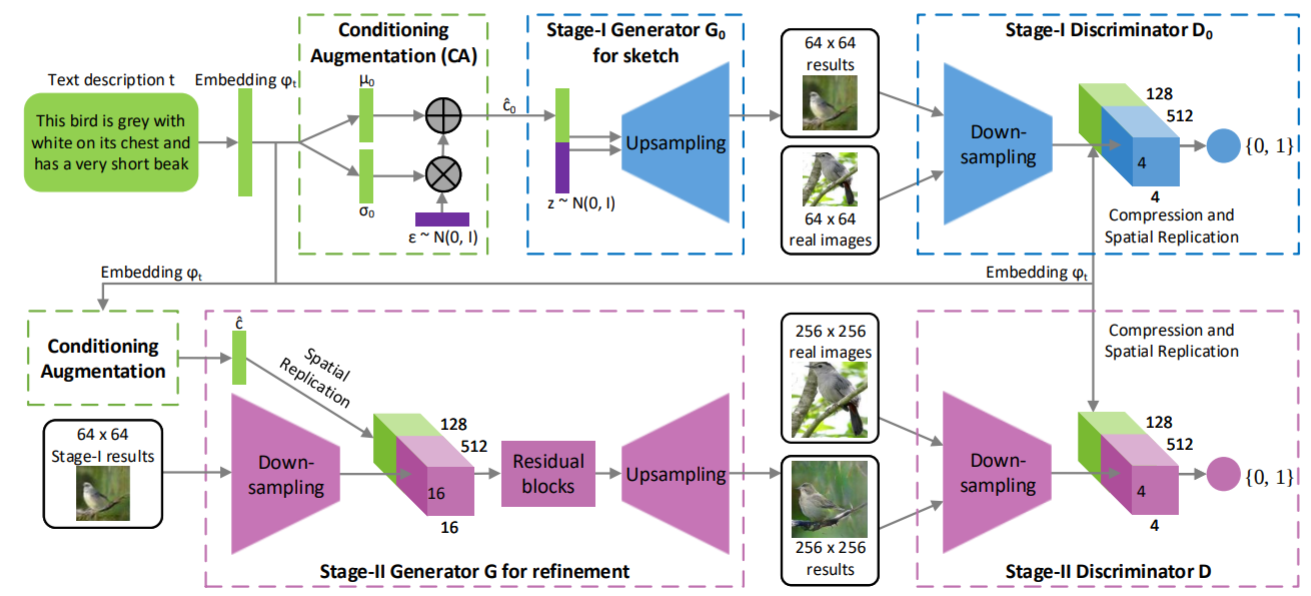

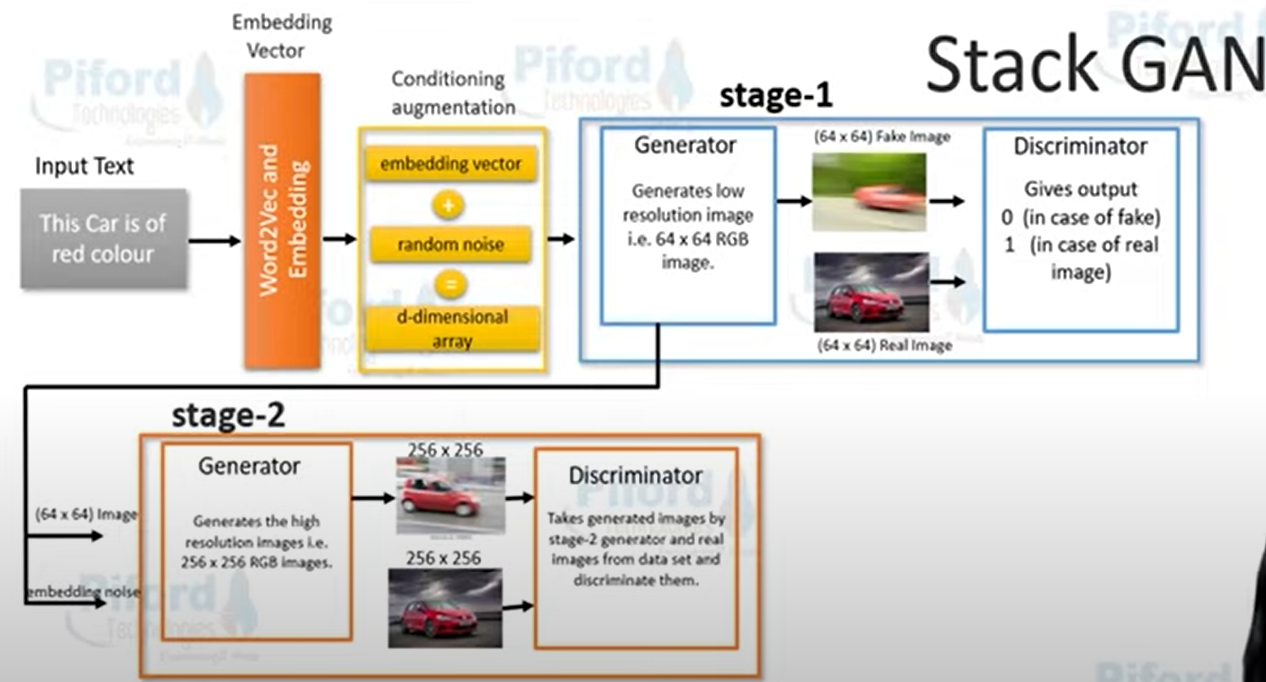

# Synthesizing high-quality images from text descriptions
## Implementation of "Stage 1 " of StackGAN
### Stage I of StackGAN
#### 1- takes input as text,
#### 2- convert the text to embedding using our pre-trained character level embedding.
#### 3- Then, we give this embedding to Conditional Augmentation (CA) and
#### 4- then to Stage I Generator which gives us low-resolution 64*64 images.

In [9]:
"""StackGAN.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pickle
import random
import time

import numpy as np
import pandas as pd
import tensorflow as tf

assert tf.__version__.startswith('2')

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, ReLU, Activation
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Dense, concatenate
from tensorflow.keras.layers import Flatten, Lambda, Reshape, ZeroPadding2D, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Conditioning Augmentation Network

### Computer doesn’t understand words, but it can represent the words in terms of something it does “understand”. That’s the “text embedding”, and it’s used as the c

In [10]:
# conditioned by the text.
def conditioning_augmentation(x):
	"""The mean_logsigma passed as argument is converted into the text conditioning variable.

	Args:
		x: The output of the text embedding passed through a FC layer with LeakyReLU non-linearity.

	Returns:
	 	c: The text conditioning variable after computation.
	"""
	mean = x[:, :128]
	log_sigma = x[:, 128:]

	stddev = tf.math.exp(log_sigma)
	epsilon = K.random_normal(shape=K.constant((mean.shape[1], ), dtype='int32'))
	c = mean + stddev * epsilon
	return c

def build_ca_network():
	"""Builds the conditioning augmentation network.
	"""
	input_layer1 = Input(shape=(1024,)) #size of the vocabulary in the text data
	mls = Dense(256)(input_layer1)
	mls = LeakyReLU(alpha=0.2)(mls)
	ca = Lambda(conditioning_augmentation)(mls)
	return Model(inputs=[input_layer1], outputs=[ca]) 

# Stage 1 Generator Network

### The generator is fed with the text captions in the form of Embedding vectors which will be used to condition its generation of features.
### A vector with random noise.

In [11]:
def UpSamplingBlock(x, num_kernels):
	"""An Upsample block with Upsampling2D, Conv2D, BatchNormalization and a ReLU activation.

	Args:
		x: The preceding layer as input.
		num_kernels: Number of kernels for the Conv2D layer.

	Returns:
		x: The final activation layer after the Upsampling block.
	"""
	x = UpSampling2D(size=(2,2))(x)
	x = Conv2D(num_kernels, kernel_size=(3,3), padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x) #prevent from mode collapse
	x = ReLU()(x)
	return x


def build_stage1_generator():

	input_layer1 = Input(shape=(1024,))
	ca = Dense(256)(input_layer1)
	ca = LeakyReLU(alpha=0.2)(ca)

	# Obtain the conditioned text
	c = Lambda(conditioning_augmentation)(ca)

	input_layer2 = Input(shape=(100,))
	concat = Concatenate(axis=1)([c, input_layer2]) 

	x = Dense(16384, use_bias=False)(concat) 
	x = ReLU()(x)
	x = Reshape((4, 4, 1024), input_shape=(16384,))(x)

	x = UpSamplingBlock(x, 512) 
	x = UpSamplingBlock(x, 256)
	x = UpSamplingBlock(x, 128)
	x = UpSamplingBlock(x, 64)   # upsampled our image to 64*64*3 

	x = Conv2D(3, kernel_size=3, padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = Activation('tanh')(x)

	stage1_gen = Model(inputs=[input_layer1, input_layer2], outputs=[x, ca]) 
	return stage1_gen


In [12]:
generator = build_stage1_generator()
generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 256)          262400      input_8[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 256)          0           dense_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128)          0           leaky_re_lu_6[0][0]              
____________________________________________________________________________________________

# Stage 1 Discriminator Network

In [13]:
def ConvBlock(x, num_kernels, kernel_size=(4,4), strides=2, activation=True):
	"""A ConvBlock with a Conv2D, BatchNormalization and LeakyReLU activation.

	Args:
		x: The preceding layer as input.
		num_kernels: Number of kernels for the Conv2D layer.

	Returns:
		x: The final activation layer after the ConvBlock block.
	"""
	x = Conv2D(num_kernels, kernel_size=kernel_size, padding='same', strides=strides, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	
	if activation:
		x = LeakyReLU(alpha=0.2)(x)
	return x


def build_embedding_compressor():
    """Build embedding compressor model
    """
    input_layer1 = Input(shape=(1024,)) 
    x = Dense(128)(input_layer1)
    x = ReLU()(x)

    model = Model(inputs=[input_layer1], outputs=[x])
    return model

# the discriminator is fed with two inputs, the feature from Generator and the text embedding
def build_stage1_discriminator():
	"""Builds the Stage 1 Discriminator that uses the 64x64 resolution images from the generator
	and the compressed and spatially replicated embedding.

	Returns:
		Stage 1 Discriminator Model for StackGAN.
	"""
	input_layer1 = Input(shape=(64, 64, 3))  

	x = Conv2D(64, kernel_size=(4,4), strides=2, padding='same', use_bias=False,
				kernel_initializer='he_uniform')(input_layer1)
	x = LeakyReLU(alpha=0.2)(x)

	x = ConvBlock(x, 128)
	x = ConvBlock(x, 256)
	x = ConvBlock(x, 512)

	# Obtain the compressed and spatially replicated text embedding
	input_layer2 = Input(shape=(4, 4, 128)) #2nd input to discriminator, text embedding
	concat = concatenate([x, input_layer2])

	x1 = Conv2D(512, kernel_size=(1,1), padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(concat)
	x1 = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x1 = LeakyReLU(alpha=0.2)(x)

	# Flatten and add a FC layer to predict.
	x1 = Flatten()(x1)
	x1 = Dense(1)(x1)
	x1 = Activation('sigmoid')(x1)

	stage1_dis = Model(inputs=[input_layer1, input_layer2], outputs=[x1])  
	return stage1_dis

In [14]:
discriminator = build_stage1_discriminator()
discriminator.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 64)   3072        input_10[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 32, 32, 64)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 16, 16, 128)  131072      leaky_re_lu_7[0][0]              
____________________________________________________________________________________________

# Stage 1 Adversarial Model (Building a GAN)

### Generator and discriminator are stacked together. Output of the former is the input of the latter.

In [15]:
# Building GAN with Generator and Discriminator

def build_adversarial(generator_model, discriminator_model):
	"""Stage 1 Adversarial model.

	Args:
		generator_model: Stage 1 Generator Model
		discriminator_model: Stage 1 Discriminator Model

	Returns:
		Adversarial Model.
	"""
	input_layer1 = Input(shape=(1024,))  
	input_layer2 = Input(shape=(100,)) 
	input_layer3 = Input(shape=(4, 4, 128)) 

	x, ca = generator_model([input_layer1, input_layer2]) #text,noise

	discriminator_model.trainable = False 

	probabilities = discriminator_model([x, input_layer3]) 
	adversarial_model = Model(inputs=[input_layer1, input_layer2, input_layer3], outputs=[probabilities, ca])
	return adversarial_model

In [16]:
ganstage1 = build_adversarial(generator, discriminator)
ganstage1.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
model_3 (Functional)            [(None, 64, 64, 3),  10270400    input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 4, 4, 128)]  0                                      

# Train Utilities

In [48]:
def checkpoint_prefix():
	checkpoint_dir = './training_checkpoints'
	checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

	return checkpoint_prefix

def adversarial_loss(y_true, y_pred):
	mean = y_pred[:, :128]
	ls = y_pred[:, 128:]
	loss = -ls + 0.5 * (-1 + tf.math.exp(2.0 * ls) + tf.math.square(mean))
	loss = K.mean(loss)
	return loss

def normalize(input_image, real_image):
	input_image = (input_image / 127.5) - 1
	real_image = (real_image / 127.5) - 1

	return input_image, real_image

def load_class_ids_filenames(class_id_path, filename_path):
	with open(class_id_path, 'rb') as file:
		class_id = pickle.load(file, encoding='latin1')

	with open(filename_path, 'rb') as file:
		filename = pickle.load(file, encoding='latin1')

	return class_id, filename

def load_text_embeddings(text_embeddings):
	with open(text_embeddings, 'rb') as file:
		embeds = pickle.load(file, encoding='latin1')
		embeds = np.array(embeds)

	return embeds

def load_bbox(data_path):
	bbox_path = data_path + '/bounding_boxes.txt'
	image_path = data_path + '/images.txt'
	bbox_df = pd.read_csv(bbox_path, delim_whitespace=True, header=None).astype(int)
	filename_df = pd.read_csv(image_path, delim_whitespace=True, header=None)

	filenames = filename_df[1].tolist()
	bbox_dict = {i[:-4]:[] for i in filenames[:2]}

	for i in range(0, len(filenames)):
		bbox = bbox_df.iloc[i][1:].tolist()
		dict_key = filenames[i][:-4]
		bbox_dict[dict_key] = bbox

	return bbox_dict

def load_images(image_path, bounding_box, size):
	"""Crops the image to the bounding box and then resizes it.
	"""
	image = Image.open(image_path).convert('RGB')
	w, h = image.size
	if bounding_box is not None:
		r = int(np.maximum(bounding_box[2], bounding_box[3]) * 0.75)
		c_x = int((bounding_box[0] + bounding_box[2]) / 2)
		c_y = int((bounding_box[1] + bounding_box[3]) / 2)
		y1 = np.maximum(0, c_y - r)
		y2 = np.minimum(h, c_y + r)
		x1 = np.maximum(0, c_x - r)
		x2 = np.minimum(w, c_x + r)
		image = image.crop([x1, y1, x2, y2])

	image = image.resize(size, PIL.Image.BILINEAR)
	return image

def load_data(filename_path, class_id_path, dataset_path, embeddings_path, size):
	"""Loads the Dataset.
	"""
	data_dir = "E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/birds"
	train_dir = data_dir + "/train"
	test_dir = data_dir + "/test"
	embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
	embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"
	filename_path_train = train_dir + "/filenames.pickle"
	filename_path_test = test_dir + "/filenames.pickle"
	class_id_path_train = train_dir + "/class_info.pickle"
	class_id_path_test = test_dir + "/class_info.pickle"
	dataset_path = "E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/CUB_200_2011"
	class_id, filenames = load_class_ids_filenames(class_id_path, filename_path)
	embeddings = load_text_embeddings(embeddings_path)
	bbox_dict = load_bbox(dataset_path)

	x, y, embeds = [], [], []

	for i, filename in enumerate(filenames):
		bbox = bbox_dict[filename]

		try:	
			image_path = f'{dataset_path}/images/{filename}.jpg'
			image = load_images(image_path, bbox, size)
			e = embeddings[i, :, :]
			embed_index = np.random.randint(0, e.shape[0] - 1)
			embed = e[embed_index, :]

			x.append(np.array(image))
			y.append(class_id[i])
			embeds.append(embed)

		except Exception as e:
			print(f'{e}')
	
	x = np.array(x)
	y = np.array(y)
	embeds = np.array(embeds)
	
	return x, y, embeds

def save_image(file, save_path):
	"""Saves the image at the specified file path.
	"""
	image = plt.figure()
	ax = image.add_subplot(1,1,1)
	ax.imshow(file)
	ax.axis("off")
	plt.savefig(save_path)

In [47]:
data_dir = "E:/amogh/StackGAN/birds"
train_dir = "E:/amogh/StackGAN/birds/train"
test_dir = "E:/amogh/StackGAN/birds/test"
embeddings_path_train = "E:/amogh/StackGAN/birds/train/char-CNN-RNN-embeddings.pickle"
embeddings_path_test ="E:/amogh/StackGAN/birds/test/char-CNN-RNN-embeddings.pickle"
filename_path_train = "E:/amogh/StackGAN/birds/train/filenames.pickle"
filename_path_test = "E:/amogh/StackGAN/birds/test/filenames.pickle"
class_id_path_train = "E:/amogh/StackGAN/birds/train/class_info.pickle"
class_id_path_test = "E:/amogh/StackGAN/birds/test/class_info.pickle"
dataset_path = "E:/amogh/StackGAN/CUB_200_2011"

In [58]:
class StackGanStage1(object):
  """StackGAN Stage 1 class."""

  data_dir = "E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/birds"
  train_dir = data_dir + "/train"
  test_dir = data_dir + "/test"
  embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
  embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"
  filename_path_train = train_dir + "/filenames.pickle"
  filename_path_test = test_dir + "/filenames.pickle"
  class_id_path_train = train_dir + "/class_info.pickle"
  class_id_path_test = test_dir + "/class_info.pickle"
  dataset_path = "E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/CUB_200_2011"
  def __init__(self, epochs=500, z_dim=100, batch_size=64, enable_function=True, stage1_generator_lr=0.0002, stage1_discriminator_lr=0.0002):
	  self.epochs = epochs
	  self.z_dim = z_dim
	  self.enable_function = enable_function
	  self.stage1_generator_lr = stage1_generator_lr
	  self.stage1_discriminator_lr = stage1_discriminator_lr
	  self.image_size = 64
	  self.conditioning_dim = 128
	  self.batch_size = batch_size
        
	  self.stage1_generator_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)
	  self.stage1_discriminator_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
        
	  self.stage1_generator = build_stage1_generator()
	  self.stage1_generator.compile(loss='mse', optimizer=self.stage1_generator_optimizer)

	  self.stage1_discriminator = build_stage1_discriminator()
	  self.stage1_discriminator.compile(loss='binary_crossentropy', optimizer=self.stage1_discriminator_optimizer)

	  self.ca_network = build_ca_network()
	  self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')

	  self.embedding_compressor = build_embedding_compressor()
	  self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')

	  self.stage1_adversarial = build_adversarial(self.stage1_generator, self.stage1_discriminator)
	  self.stage1_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], loss_weights=[1, 2.0], optimizer=self.stage1_generator_optimizer)

	  self.checkpoint1 = tf.train.Checkpoint(
        	generator_optimizer=self.stage1_generator_optimizer,
        	discriminator_optimizer=self.stage1_discriminator_optimizer,
        	generator=self.stage1_generator,
        	discriminator=self.stage1_discriminator)

  def visualize_stage1(self):
	  """Running Tensorboard visualizations.
		"""
	  tb = TensorBoard(log_dir="logs/".format(time.time()))
	  tb.set_model(self.stage1_generator)
	  tb.set_model(self.stage1_discriminator)
	  tb.set_model(self.ca_network)
	  tb.set_model(self.embedding_compressor)

  def train_stage1(self):
	  """Trains the stage1 StackGAN.
    """
	  x_train, y_train, train_embeds = load_data(filename_path=filename_path_train, class_id_path=class_id_path_train,
      dataset_path=dataset_path, embeddings_path=embeddings_path_train, size=(64, 64))

	  x_test, y_test, test_embeds = load_data(filename_path=filename_path_test, class_id_path=class_id_path_test, 
      dataset_path=dataset_path, embeddings_path=embeddings_path_test, size=(64, 64))

	  real = np.ones((self.batch_size, 1), dtype='float') * 0.9
	  fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

	  for epoch in range(self.epochs):
		  print(f'Epoch: {epoch}')

		  gen_loss = []
		  dis_loss = []

		  num_batches = int(x_train.shape[0] / self.batch_size)

		  for i in range(num_batches):

		    latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
		    embedding_text = train_embeds[i * self.batch_size:(i + 1) * self.batch_size]
		    compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
		    compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, 128))
		    compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

		    image_batch = x_train[i * self.batch_size:(i+1) * self.batch_size]
		    image_batch = (image_batch - 127.5) / 127.5

		    gen_images, _ = self.stage1_generator.predict([embedding_text, latent_space])

		    discriminator_loss = self.stage1_discriminator.train_on_batch([image_batch, compressed_embedding], 
					np.reshape(real, (self.batch_size, 1)))

		    discriminator_loss_gen = self.stage1_discriminator.train_on_batch([gen_images, compressed_embedding],
					np.reshape(fake, (self.batch_size, 1)))

		    discriminator_loss_wrong = self.stage1_discriminator.train_on_batch([gen_images[: self.batch_size-1], compressed_embedding[1:]], 
					np.reshape(fake[1:], (self.batch_size-1, 1)))

		    # Discriminator loss
		    d_loss = 0.5 * np.add(discriminator_loss, 0.5 * np.add(discriminator_loss_gen, discriminator_loss_wrong))
		    dis_loss.append(d_loss)

		    print(f'Discriminator Loss: {d_loss}')

		    # Generator loss
		    g_loss = self.stage1_adversarial.train_on_batch([embedding_text, latent_space, compressed_embedding],
					[K.ones((self.batch_size, 1)) * 0.9, K.ones((self.batch_size, 256)) * 0.9])

		    print(f'Generator Loss: {g_loss}')
		    gen_loss.append(g_loss)

		    if epoch % 5 == 0:
				    latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
				    embedding_batch = test_embeds[0 : self.batch_size]
				    gen_images, _ = self.stage1_generator.predict_on_batch([embedding_batch, latent_space])

				    for i, image in enumerate(gen_images[:10]):
				        save_image(image, f"E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/test/gen_1_{epoch}_{i}")

		    if epoch % 25 == 0:
		      self.stage1_generator.save_weights("E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage1_gen.h5")
		      self.stage1_discriminator.save_weights("E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage1_disc.h5")
		      self.ca_network.save_weights("E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage1_ca.h5")
		      self.embedding_compressor.save_weights("E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage1_embco.h5")
		      self.stage1_adversarial.save_weights("E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage1_adv.h5")      

	  self.stage1_generator.save_weights("E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage1_gen.h5")
	  self.stage1_discriminator.save_weights("E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage1_disc.h5")

C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch: 0
Discriminator Loss: 1.0911019993945956
Generator Loss: [0.9533270001411438, 0.9163563251495361, 0.01848534867167473]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.3502548416145146
Generator Loss: [0.3853065073490143, 0.344610333442688, 0.02034808322787285]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.37884663697332144
Generator Loss: [0.5909532904624939, 0.5462749004364014, 0.02233920618891716]


<ipython-input-48-9e8a9be522a2>:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  image = plt.figure()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping in

Discriminator Loss: 0.5650026738876477
Generator Loss: [2.434767007827759, 2.385593891143799, 0.024586530402302742]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.43756864173337817
Generator Loss: [3.0822126865386963, 3.0413413047790527, 0.020435653626918793]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.6032244171947241
Generator Loss: [1.6748406887054443, 1.635851502418518, 0.019494567066431046]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.3190442359773442
Generator Loss: [0.39408835768699646, 0.3620373606681824, 0.016025502234697342]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.36070880002807826
Generator Loss: [0.4695144593715668, 0.4165434241294861, 0.026485513895750046]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.25758766615763307
Generator Loss: [0.4221280813217163, 0.3530725836753845, 0.034527748823165894]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.21868871280457824
Generator Loss: [0.3969937264919281, 0.3468598425388336, 0.025066940113902092]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.2017183939460665
Generator Loss: [0.43600648641586304, 0.4017983078956604, 0.01710408553481102]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19387718453072011
Generator Loss: [0.6495047807693481, 0.6162902116775513, 0.01660727895796299]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1962892790324986
Generator Loss: [0.38154691457748413, 0.34628212451934814, 0.017632393166422844]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.22500154562294483
Generator Loss: [0.3706950545310974, 0.3395814299583435, 0.015556804835796356]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.2177248260122724
Generator Loss: [0.492775559425354, 0.4373413920402527, 0.027717091143131256]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19823016453301534
Generator Loss: [0.3950093686580658, 0.3558890223503113, 0.01956016942858696]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1938489016611129
Generator Loss: [0.42888563871383667, 0.3963201642036438, 0.016282737255096436]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18538607825757936
Generator Loss: [0.43493878841400146, 0.40714550018310547, 0.013896636664867401]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18419981212355196
Generator Loss: [0.37260541319847107, 0.3453308939933777, 0.013637261465191841]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.20451393048278987
Generator Loss: [0.4135485589504242, 0.38500097393989563, 0.014273792505264282]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19484137755353004
Generator Loss: [0.3721122443675995, 0.3475632667541504, 0.012274491600692272]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19870780548080802
Generator Loss: [0.4516744017601013, 0.42944565415382385, 0.01111437939107418]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1919752890826203
Generator Loss: [0.6162177920341492, 0.5910426378250122, 0.012587577104568481]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.6389705612816954
Generator Loss: [17.363826751708984, 17.329849243164062, 0.01698830910027027]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 1.3857846625614911
Generator Loss: [0.6395204067230225, 0.6091934442520142, 0.015163466334342957]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.4391401156774464
Generator Loss: [9.72235107421875, 9.694639205932617, 0.013856079429388046]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.28035275446018204
Generator Loss: [0.6187969446182251, 0.5896779298782349, 0.014559515751898289]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.547268721172741
Generator Loss: [13.982645034790039, 13.938556671142578, 0.022044111043214798]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.37255980489908325
Generator Loss: [3.1196916103363037, 3.079744815826416, 0.019973382353782654]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.40279860836682246
Generator Loss: [5.116703510284424, 5.08638858795166, 0.015157538466155529]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.3232029111528395
Generator Loss: [2.0837936401367188, 2.0508687496185303, 0.016462428495287895]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.24928120109737506
Generator Loss: [0.6239385008811951, 0.5820536017417908, 0.020942462608218193]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.23676820481023242
Generator Loss: [0.4063517451286316, 0.37080666422843933, 0.01777254417538643]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.20380118184402818
Generator Loss: [0.5651072263717651, 0.529923141002655, 0.01759203150868416]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.21456302501064783
Generator Loss: [0.748641848564148, 0.7159514427185059, 0.01634519174695015]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.22157094965223223
Generator Loss: [0.45205873250961304, 0.4176788628101349, 0.017189932987093925]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.199676909178379
Generator Loss: [0.6043277382850647, 0.5691592693328857, 0.017584245651960373]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1989978528872598
Generator Loss: [0.43320733308792114, 0.39718925952911377, 0.01800902932882309]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19293164170812815
Generator Loss: [0.5351990461349487, 0.4974350333213806, 0.01888199895620346]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.193893184827175
Generator Loss: [0.4946635365486145, 0.4662407636642456, 0.014211380854249]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18697731706197374
Generator Loss: [0.42857277393341064, 0.39860033988952637, 0.014986217021942139]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19046415798948146
Generator Loss: [0.5820993781089783, 0.5511898994445801, 0.015454728156328201]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.21185241718194447
Generator Loss: [0.44553256034851074, 0.41016435623168945, 0.017684102058410645]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.20770727258059196
Generator Loss: [0.3916762173175812, 0.3599804937839508, 0.015847858041524887]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19939854531548917
Generator Loss: [0.43688908219337463, 0.39674675464630127, 0.020071163773536682]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19266272062668577
Generator Loss: [0.8456646203994751, 0.8127930164337158, 0.016435792669653893]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1825244008214213
Generator Loss: [0.839011549949646, 0.8080362677574158, 0.015487651340663433]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18444411840755492
Generator Loss: [0.555889904499054, 0.5115620493888855, 0.022163935005664825]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1970179512281902
Generator Loss: [0.3837352395057678, 0.3388211727142334, 0.02245704084634781]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.200942365830997
Generator Loss: [0.4204212427139282, 0.3908952474594116, 0.0147629976272583]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.20563097232661676
Generator Loss: [0.4343133866786957, 0.40364766120910645, 0.015332859009504318]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19263326385407709
Generator Loss: [0.3652743101119995, 0.3443360924720764, 0.01046910509467125]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18132166838040575
Generator Loss: [0.3850499391555786, 0.3517463207244873, 0.016651809215545654]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17652101174462587
Generator Loss: [0.44643455743789673, 0.4210132360458374, 0.01271066628396511]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1749122535402421
Generator Loss: [0.5981501936912537, 0.5666961669921875, 0.015727005898952484]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1793524379900191
Generator Loss: [0.4727945029735565, 0.43937182426452637, 0.016711339354515076]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1783436521218391
Generator Loss: [0.39011427760124207, 0.3476499617099762, 0.021232154220342636]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17615399847272784
Generator Loss: [1.2051063776016235, 1.1713767051696777, 0.01686481013894081]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19174842126085423
Generator Loss: [1.6965444087982178, 1.667984127998352, 0.014280149713158607]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19666693330509588
Generator Loss: [0.9161683917045593, 0.882152795791626, 0.017007794231176376]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18561054355814122
Generator Loss: [0.6300800442695618, 0.6049998998641968, 0.012540058232843876]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19816337029624265
Generator Loss: [1.5403245687484741, 1.5146493911743164, 0.012837609276175499]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18753485311754048
Generator Loss: [2.1340973377227783, 2.103771686553955, 0.015162868425250053]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.2060844146180898
Generator Loss: [0.7196412086486816, 0.687603235244751, 0.016018975526094437]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.21326942640007474
Generator Loss: [0.443615198135376, 0.39656883478164673, 0.023523176088929176]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.197841519897338
Generator Loss: [1.1100620031356812, 1.0836710929870605, 0.013195476494729519]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.4885293692423841
Generator Loss: [20.495019912719727, 20.468902587890625, 0.013058297336101532]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.6704181795248587
Generator Loss: [0.6506857872009277, 0.6207369565963745, 0.014974408783018589]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.2640843396220589
Generator Loss: [0.7405324578285217, 0.7145093679428101, 0.013011541217565536]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.2497599683556473
Generator Loss: [0.5604541897773743, 0.5266278386116028, 0.01691318489611149]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.22358108722437464
Generator Loss: [0.4532342255115509, 0.41142088174819946, 0.020906668156385422]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.21163645239857942
Generator Loss: [3.7915873527526855, 3.7692389488220215, 0.01117425411939621]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.20395715731137898
Generator Loss: [0.8558854460716248, 0.8305795192718506, 0.012652971781790257]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19815644390473608
Generator Loss: [1.2721720933914185, 1.2486404180526733, 0.011765852570533752]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.21258370954092243
Generator Loss: [0.8272217512130737, 0.7984925508499146, 0.014364615082740784]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19047425032840692
Generator Loss: [0.7917656898498535, 0.7673535346984863, 0.01220608688890934]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19111956364668004
Generator Loss: [0.5572492480278015, 0.5325430631637573, 0.012353080324828625]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18074274320565564
Generator Loss: [0.3825508952140808, 0.35311460494995117, 0.014718146063387394]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.2415710293378197
Generator Loss: [0.5524631142616272, 0.5218023061752319, 0.015330403111875057]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.21858623485968565
Generator Loss: [0.44721436500549316, 0.42011532187461853, 0.01354951597750187]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19568123462522635
Generator Loss: [0.3731473982334137, 0.34025299549102783, 0.01644720509648323]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19781134231288888
Generator Loss: [0.4650973677635193, 0.4369505047798157, 0.01407342404127121]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18477971358879586
Generator Loss: [0.39773857593536377, 0.36665600538253784, 0.01554128434509039]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18255787205634988
Generator Loss: [0.3790513575077057, 0.34874582290649414, 0.015152763575315475]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1839180784436394
Generator Loss: [0.3682979643344879, 0.34112977981567383, 0.013584094122052193]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1758855935140673
Generator Loss: [0.37323957681655884, 0.3495181202888489, 0.011860721744596958]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17658909370697984
Generator Loss: [0.36708691716194153, 0.33785995841026306, 0.014613485895097256]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17580090532283066
Generator Loss: [0.39915308356285095, 0.36730605363845825, 0.015923509374260902]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18336767260007036
Generator Loss: [0.3892609179019928, 0.3534695506095886, 0.01789567992091179]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.19907564259847277
Generator Loss: [0.38071170449256897, 0.3508436679840088, 0.014934014528989792]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17986167923027097
Generator Loss: [0.3797108232975006, 0.34956932067871094, 0.015070749446749687]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1913716218277841
Generator Loss: [0.407649427652359, 0.3737544119358063, 0.016947507858276367]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18176815902188537
Generator Loss: [0.38900792598724365, 0.35626891255378723, 0.016369499266147614]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1760999483130945
Generator Loss: [0.5146526098251343, 0.47952374815940857, 0.01756441965699196]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17416528031026246
Generator Loss: [0.37021708488464355, 0.33875247836112976, 0.0157322995364666]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17488772264005092
Generator Loss: [0.3853161633014679, 0.3502536118030548, 0.017531272023916245]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17805989496446273
Generator Loss: [0.3730916380882263, 0.33582597970962524, 0.018632836639881134]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1761272582680249
Generator Loss: [0.4144648313522339, 0.3772958517074585, 0.018584487959742546]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17492647650578874
Generator Loss: [0.3659929633140564, 0.3339267373085022, 0.0160331092774868]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17689467950094695
Generator Loss: [0.37309595942497253, 0.3404533565044403, 0.016321297734975815]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17637425048178557
Generator Loss: [0.3622402250766754, 0.33782464265823364, 0.012207794934511185]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1729688268233076
Generator Loss: [0.36390450596809387, 0.3386525511741638, 0.012625981122255325]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.18096132315986324
Generator Loss: [0.39166349172592163, 0.36146482825279236, 0.015099326148629189]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17705257476336556
Generator Loss: [0.3674781024456024, 0.34177425503730774, 0.012851923704147339]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17434866557232453
Generator Loss: [0.3584482967853546, 0.33246737718582153, 0.012990457005798817]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17291094590109424
Generator Loss: [0.3807240426540375, 0.35562729835510254, 0.01254837866872549]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17429677694599377
Generator Loss: [0.35728591680526733, 0.3319927453994751, 0.012646579183638096]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17148339676350588
Generator Loss: [0.3588249087333679, 0.3371007740497589, 0.010862067341804504]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17735279254156922
Generator Loss: [0.35923492908477783, 0.33396872878074646, 0.012633102014660835]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17972189036663622
Generator Loss: [0.3602924346923828, 0.33399397134780884, 0.013149239122867584]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17830507273538387
Generator Loss: [0.38244059681892395, 0.3542031943798065, 0.014118700288236141]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17326005239465303
Generator Loss: [0.36217331886291504, 0.32970207929611206, 0.016235627233982086]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.16970576889343647
Generator Loss: [0.365318238735199, 0.3394578993320465, 0.012930162250995636]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.16917737435142044
Generator Loss: [0.359229177236557, 0.33050990104675293, 0.014359640888869762]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.16912703962952946
Generator Loss: [0.364632785320282, 0.33294111490249634, 0.01584583707153797]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1736506130982889
Generator Loss: [0.3765266239643097, 0.3494989275932312, 0.013513852842152119]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1740829604495957
Generator Loss: [0.35398250818252563, 0.32970288395881653, 0.01213981956243515]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17391735998717195
Generator Loss: [0.35764050483703613, 0.33089786767959595, 0.013371314853429794]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17207050401157176
Generator Loss: [0.3596489429473877, 0.33691468834877014, 0.011367127299308777]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.16980748979676719
Generator Loss: [0.37470701336860657, 0.34914296865463257, 0.012782018631696701]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1709266583347926
Generator Loss: [0.3540710210800171, 0.3306450843811035, 0.011712975800037384]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.16973158736618643
Generator Loss: [0.35700079798698425, 0.3314722776412964, 0.012764260172843933]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1711837939437828
Generator Loss: [0.3841707408428192, 0.3622280955314636, 0.010971324518322945]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17227246303809807
Generator Loss: [0.34921735525131226, 0.3290712833404541, 0.010073032230138779]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17134160810383037
Generator Loss: [0.35995814204216003, 0.3331305980682373, 0.013413775712251663]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1683051286781847
Generator Loss: [0.37008795142173767, 0.3444055914878845, 0.012841175310313702]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17633565388678107
Generator Loss: [0.3906908631324768, 0.3684511184692383, 0.011119866743683815]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.17351040387165995
Generator Loss: [0.36285078525543213, 0.33124077320098877, 0.01580500416457653]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.16917096280667465
Generator Loss: [0.37133222818374634, 0.3412209749221802, 0.015055627562105656]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.16842111515143188
Generator Loss: [0.3692534565925598, 0.3473361134529114, 0.01095866784453392]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1697474844277167
Generator Loss: [0.36265435814857483, 0.33520108461380005, 0.013726633042097092]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.16919420688645914
Generator Loss: [0.38204488158226013, 0.3585379719734192, 0.011753453873097897]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.16723781004475313
Generator Loss: [0.3933384120464325, 0.3732544183731079, 0.010041993111371994]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.16772358947855537
Generator Loss: [0.3574293851852417, 0.3355334997177124, 0.01094793900847435]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.16867274302057922
Generator Loss: [0.3559626042842865, 0.3372207581996918, 0.00937091838568449]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1662413106605527
Generator Loss: [0.35188180208206177, 0.3344772160053253, 0.008702298626303673]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.1672340921650175
Generator Loss: [0.3745291829109192, 0.3545425534248352, 0.009993321262300014]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Discriminator Loss: 0.16971990350430133
Generator Loss: [0.3695870041847229, 0.34862220287323, 0.01048240065574646]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 1
Discriminator Loss: 0.17294575010600965
Generator Loss: [0.3781171441078186, 0.35576552152633667, 0.011175809428095818]
Discriminator Loss: 0.16742502646047797
Generator Loss: [0.36404669284820557, 0.3388589918613434, 0.012593850493431091]
Discriminator Loss: 0.168508446397027
Generator Loss: [0.35792118310928345, 0.33053380250930786, 0.01369369775056839]
Discriminator Loss: 0.17028097582078772
Generator Loss: [0.4183879792690277, 0.38889625668525696, 0.014745857566595078]
Discriminator Loss: 0.1729832764758612
Generator Loss: [0.3741076588630676, 0.34986525774002075, 0.012121208012104034]
Discriminator Loss: 0.17514088768075453
Generator Loss: [0.3546610176563263, 0.3322325646877289, 0.011214228346943855]
Discriminator Loss: 0.16967681961978087
Generator Loss: [0.3533726632595062, 0.3341507017612457, 0.009610974229872227]
Discriminator Loss: 0.16952773217417416
Generator Loss: [0.3845173120498657, 0.3564842939376831, 0.014016516506671906]
Discriminator Loss: 0.170225928930449

Discriminator Loss: 0.2146519371890463
Generator Loss: [0.7320312857627869, 0.7121398448944092, 0.009945710189640522]
Discriminator Loss: 0.17591317120241
Generator Loss: [0.7275115251541138, 0.7036329507827759, 0.011939287185668945]
Discriminator Loss: 0.17857616761466488
Generator Loss: [1.190258502960205, 1.1760175228118896, 0.007120502181351185]
Discriminator Loss: 0.4633731395006263
Generator Loss: [33.70835876464844, 33.69340515136719, 0.007476827595382929]
Discriminator Loss: 2.5374542772771624
Generator Loss: [28.334999084472656, 28.32089614868164, 0.007051565684378147]
Discriminator Loss: 0.9116704053296019
Generator Loss: [15.21850872039795, 15.198979377746582, 0.009764745831489563]
Discriminator Loss: 0.27975717357185204
Generator Loss: [0.9811643958091736, 0.959836483001709, 0.01066394243389368]
Discriminator Loss: 0.3632632866612346
Generator Loss: [25.551471710205078, 25.526226043701172, 0.01262254361063242]
Discriminator Loss: 0.6067974277181011
Generator Loss: [30.01235

Discriminator Loss: 0.19567585827462608
Generator Loss: [0.3541526198387146, 0.33478641510009766, 0.009683100506663322]
Discriminator Loss: 0.1794154333347251
Generator Loss: [0.3495936095714569, 0.3277286887168884, 0.01093246042728424]
Discriminator Loss: 0.17536774618565687
Generator Loss: [0.35311463475227356, 0.32912498712539673, 0.011994821950793266]
Discriminator Loss: 0.18103507954947418
Generator Loss: [0.3537465035915375, 0.33133500814437866, 0.011205747723579407]
Discriminator Loss: 0.1702694163632259
Generator Loss: [0.3503025472164154, 0.3305000960826874, 0.009901227429509163]
Discriminator Loss: 0.16816070574714104
Generator Loss: [0.3489910662174225, 0.3313369154930115, 0.008827069774270058]
Discriminator Loss: 0.16889917320077075
Generator Loss: [0.373320609331131, 0.35610491037368774, 0.008607851341366768]
Discriminator Loss: 0.16713220901692694
Generator Loss: [0.3760284185409546, 0.35501015186309814, 0.010509133338928223]
Discriminator Loss: 0.1782551463911659
Generat

Discriminator Loss: 0.16387174339342891
Generator Loss: [0.37115487456321716, 0.3562440872192383, 0.00745539041236043]
Discriminator Loss: 0.16413976000330877
Generator Loss: [0.37084493041038513, 0.35180890560150146, 0.00951800961047411]
Discriminator Loss: 0.16515671046363423
Generator Loss: [0.343732088804245, 0.3291242718696594, 0.007303912192583084]
Discriminator Loss: 0.16504410111519974
Generator Loss: [0.3991716504096985, 0.3793525695800781, 0.009909545071423054]
Discriminator Loss: 0.16526026910651126
Generator Loss: [0.36343953013420105, 0.34301644563674927, 0.010211539454758167]
Discriminator Loss: 0.16561055522834067
Generator Loss: [0.3546231985092163, 0.32925719022750854, 0.012682996690273285]
Discriminator Loss: 0.16496313881361857
Generator Loss: [0.3612894117832184, 0.34074243903160095, 0.010273491032421589]
Discriminator Loss: 0.16454211209565983
Generator Loss: [0.3497917354106903, 0.33098286390304565, 0.009404432028532028]
Discriminator Loss: 0.16503256671785493
Gen

Discriminator Loss: 0.17288595432364673
Generator Loss: [0.34333011507987976, 0.33079174160957336, 0.0062691932544112206]
Discriminator Loss: 0.16419012507685693
Generator Loss: [0.35002484917640686, 0.33590924739837646, 0.007057796232402325]
Discriminator Loss: 0.1653210119020514


KeyboardInterrupt: 

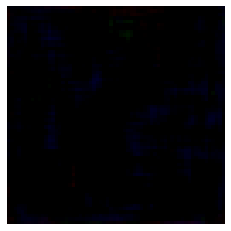

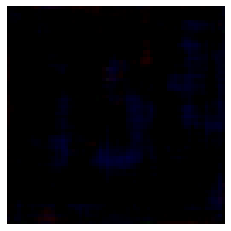

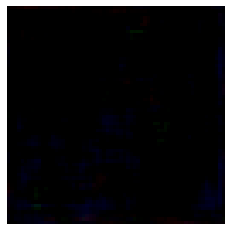

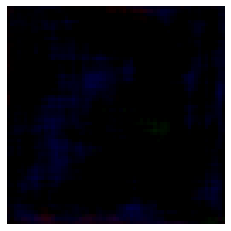

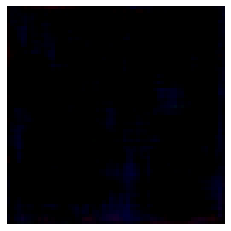

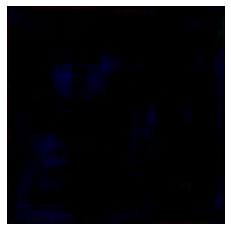

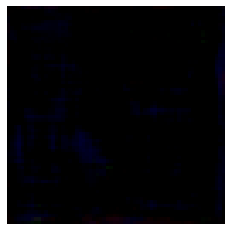

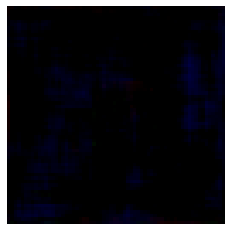

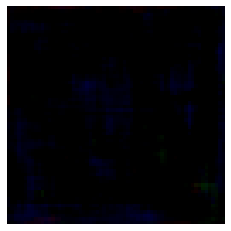

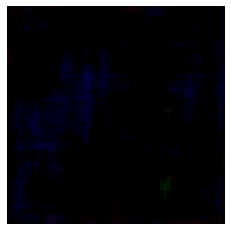

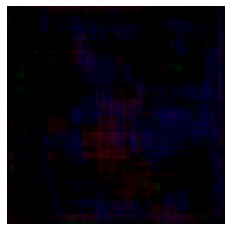

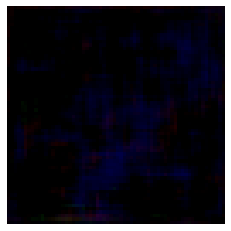

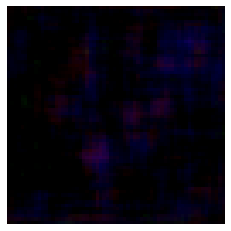

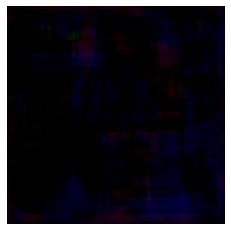

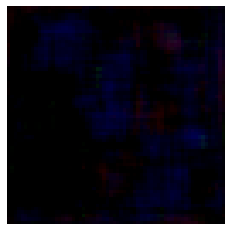

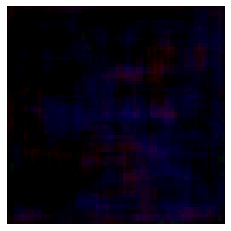

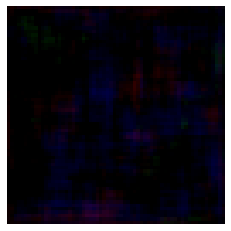

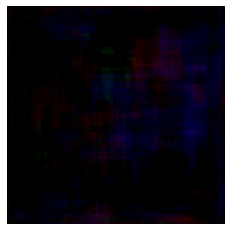

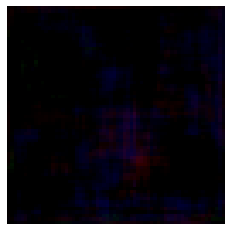

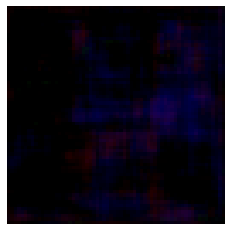

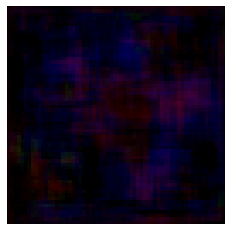

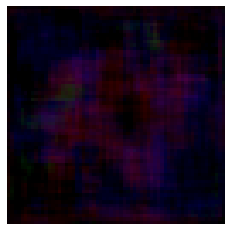

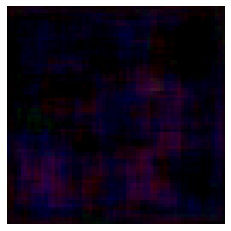

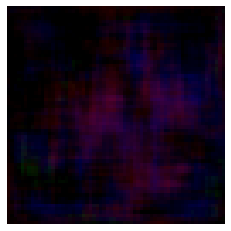

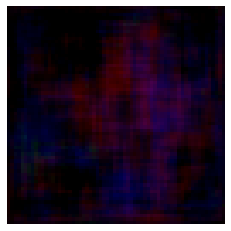

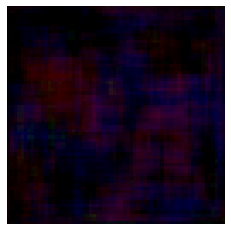

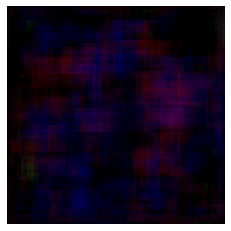

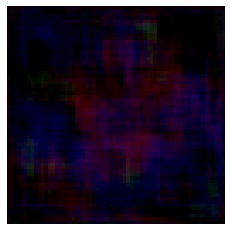

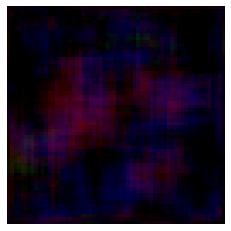

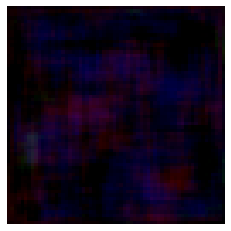

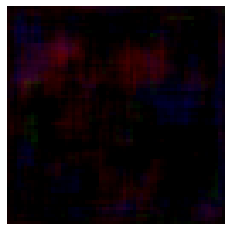

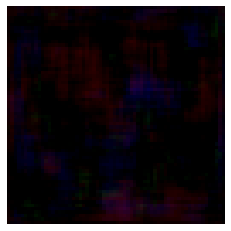

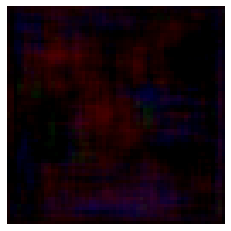

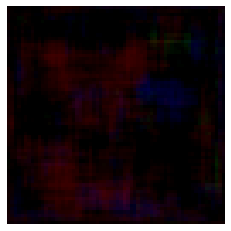

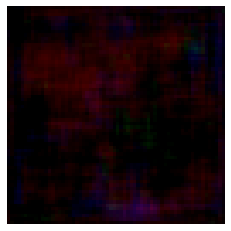

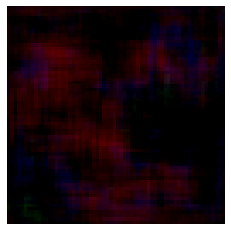

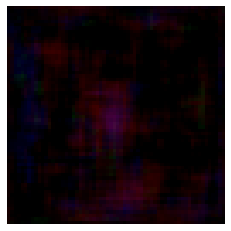

Error in callback <function flush_figures at 0x00000125741A9550> (for post_execute):


KeyboardInterrupt: 

In [59]:
stage1 = StackGanStage1()
stage1.train_stage1()

# Check test folder for gernerated images from Stage1 Generator
## Let's Implement Stage 2 Generator

In [60]:
############################################################
# Stage 2 Generator Network
############################################################

def concat_along_dims(inputs):
	"""Joins the conditioned text with the encoded image along the dimensions.

	Args:
		inputs: consisting of conditioned text and encoded images as [c,x].

	Returns:
		Joint block along the dimensions.
	"""
	c = inputs[0]
	x = inputs[1]

	c = K.expand_dims(c, axis=1)
	c = K.expand_dims(c, axis=1)
	c = K.tile(c, [1, 16, 16, 1])
	return K.concatenate([c, x], axis = 3)

def residual_block(input):
	"""Residual block with plain identity connections.

	Args:
		inputs: input layer or an encoded layer

	Returns:
		Layer with computed identity mapping.
	"""
	x = Conv2D(512, kernel_size=(3,3), padding='same', use_bias=False,
				kernel_initializer='he_uniform')(input)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)
	
	x = Conv2D(512, kernel_size=(3,3), padding='same', use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	
	x = add([x, input])
	x = ReLU()(x)

	return x

def build_stage2_generator():
	"""Build the Stage 2 Generator Network using the conditioning text and images from stage 1.

	Returns:
		Stage 2 Generator Model for StackGAN.
	"""
	input_layer1 = Input(shape=(1024,))
	input_images = Input(shape=(64, 64, 3))

	# Conditioning Augmentation
	ca = Dense(256)(input_layer1)
	mls = LeakyReLU(alpha=0.2)(ca)
	c = Lambda(conditioning_augmentation)(mls)

	# Downsampling block
	x = ZeroPadding2D(padding=(1,1))(input_images)
	x = Conv2D(128, kernel_size=(3,3), strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = ReLU()(x)

	x = ZeroPadding2D(padding=(1,1))(x)
	x = Conv2D(256, kernel_size=(4,4), strides=2, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)

	x = ZeroPadding2D(padding=(1,1))(x)
	x = Conv2D(512, kernel_size=(4,4), strides=2, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)

	# Concatenate text conditioning block with the encoded image
	concat = concat_along_dims([c, x])

	# Residual Blocks
	x = ZeroPadding2D(padding=(1,1))(concat)
	x = Conv2D(512, kernel_size=(3,3), use_bias=False, kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)

	x = residual_block(x)
	x = residual_block(x)
	x = residual_block(x)
	x = residual_block(x)

	# Upsampling Blocks
	x = UpSamplingBlock(x, 512)
	x = UpSamplingBlock(x, 256)
	x = UpSamplingBlock(x, 128)
	x = UpSamplingBlock(x, 64)

	x = Conv2D(3, kernel_size=(3,3), padding='same', use_bias=False, kernel_initializer='he_uniform')(x)
	x = Activation('tanh')(x)
	
	stage2_gen = Model(inputs=[input_layer1, input_images], outputs=[x, mls])
	return stage2_gen

In [61]:
generator_stage2 = build_stage2_generator()
generator_stage2.summary()

Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_115 (InputLayer)          [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 66, 66, 3)    0           input_115[0][0]                  
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 64, 64, 128)  3456        zero_padding2d[0][0]             
__________________________________________________________________________________________________
re_lu_76 (ReLU)                 (None, 64, 64, 128)  0           conv2d_130[0][0]                 
___________________________________________________________________________________________

In [62]:
############################################################
# Stage 2 Discriminator Network
############################################################

def build_stage2_discriminator():
	"""Builds the Stage 2 Discriminator that uses the 256x256 resolution images from the generator
	and the compressed and spatially replicated embeddings.

	Returns:
		Stage 2 Discriminator Model for StackGAN.
	"""
	input_layer1 = Input(shape=(256, 256, 3))

	x = Conv2D(64, kernel_size=(4,4), padding='same', strides=2, use_bias=False,
				kernel_initializer='he_uniform')(input_layer1)
	x = LeakyReLU(alpha=0.2)(x)

	x = ConvBlock(x, 128)
	x = ConvBlock(x, 256)
	x = ConvBlock(x, 512)
	x = ConvBlock(x, 1024)
	x = ConvBlock(x, 2048)
	x = ConvBlock(x, 1024, (1,1), 1)
	x = ConvBlock(x, 512, (1,1), 1, False)

	x1 = ConvBlock(x, 128, (1,1), 1)
	x1 = ConvBlock(x1, 128, (3,3), 1)
	x1 = ConvBlock(x1, 512, (3,3), 1, False)

	x2 = add([x, x1])
	x2 = LeakyReLU(alpha=0.2)(x2)

	# Concatenate compressed and spatially replicated embedding
	input_layer2 = Input(shape=(4, 4, 128))
	concat = concatenate([x2, input_layer2])

	x3 = Conv2D(512, kernel_size=(1,1), strides=1, padding='same', kernel_initializer='he_uniform')(concat)
	x3 = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x3)
	x3 = LeakyReLU(alpha=0.2)(x3)

	# Flatten and add a FC layer
	x3 = Flatten()(x3)
	x3 = Dense(1)(x3)
	x3 = Activation('sigmoid')(x3)

	stage2_dis = Model(inputs=[input_layer1, input_layer2], outputs=[x3])
	return stage2_dis

In [63]:
discriminator_stage2 = build_stage2_discriminator()
discriminator_stage2.summary()

Model: "model_62"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_116 (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 128, 128, 64) 3072        input_116[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_90 (LeakyReLU)      (None, 128, 128, 64) 0           conv2d_147[0][0]                 
__________________________________________________________________________________________________
conv2d_148 (Conv2D)             (None, 64, 64, 128)  131072      leaky_re_lu_90[0][0]             
___________________________________________________________________________________________

In [64]:
############################################################
# Stage 2 Adversarial Model
############################################################

def stage2_adversarial_network(stage2_disc, stage2_gen, stage1_gen):
	"""Stage 2 Adversarial Network.

	Args:
		stage2_disc: Stage 2 Discriminator Model.
		stage2_gen: Stage 2 Generator Model.
		stage1_gen: Stage 1 Generator Model.

	Returns:
		Stage 2 Adversarial network.
	"""
	conditioned_embedding = Input(shape=(1024, ))
	latent_space = Input(shape=(100, ))
	compressed_replicated = Input(shape=(4, 4, 128))
    
	#the discriminator is trained separately and stage1_gen already trained, and this is the reason why we freeze its layers by setting the property trainable=false
	input_images, ca = stage1_gen([conditioned_embedding, latent_space])
	stage2_disc.trainable = False
	stage1_gen.trainable = False

	images, ca2 = stage2_gen([conditioned_embedding, input_images])
	probability = stage2_disc([images, compressed_replicated])

	return Model(inputs=[conditioned_embedding, latent_space, compressed_replicated],
		outputs=[probability, ca2])

In [65]:
adversarial_stage2 = stage2_adversarial_network(discriminator_stage2, generator_stage2, generator)
adversarial_stage2.summary()

Model: "model_63"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_118 (InputLayer)          [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_119 (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
model_3 (Functional)            [(None, 64, 64, 3),  10270400    input_118[0][0]                  
                                                                 input_119[0][0]                  
__________________________________________________________________________________________________
model_61 (Functional)           [(None, 256, 256, 3) 28645440    input_118[0][0]           

In [68]:
class StackGanStage2(object):
	"""StackGAN Stage 2 class.

	Args:
		epochs: Number of epochs
		z_dim: Latent space dimensions
		batch_size: Batch Size
		enable_function: If True, training function is decorated with tf.function
		stage2_generator_lr: Learning rate for stage 2 generator
		stage2_discriminator_lr: Learning rate for stage 2 discriminator
	"""
	def __init__(self, epochs=500, z_dim=100, batch_size=64, enable_function=True, stage2_generator_lr=0.0002, stage2_discriminator_lr=0.0002):
		self.epochs = epochs
		self.z_dim = z_dim
		self.enable_function = enable_function
		self.stage1_generator_lr = stage2_generator_lr
		self.stage1_discriminator_lr = stage2_discriminator_lr
		self.low_image_size = 64
		self.high_image_size = 256
		self.conditioning_dim = 128
		self.batch_size = batch_size
		self.stage2_generator_optimizer = Adam(lr=stage2_generator_lr, beta_1=0.5, beta_2=0.999)
		self.stage2_discriminator_optimizer = Adam(lr=stage2_discriminator_lr, beta_1=0.5, beta_2=0.999)
		self.stage1_generator = build_stage1_generator()
		self.stage1_generator.compile(loss='binary_crossentropy', optimizer=self.stage2_generator_optimizer)
		self.stage1_generator.load_weights("E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage1_gen.h5")
		self.stage2_generator = build_stage2_generator()
		self.stage2_generator.compile(loss='binary_crossentropy', optimizer=self.stage2_generator_optimizer)

		self.stage2_discriminator = build_stage2_discriminator()
		self.stage2_discriminator.compile(loss='binary_crossentropy', optimizer=self.stage2_discriminator_optimizer)

		self.ca_network = build_ca_network()
		self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')

		self.embedding_compressor = build_embedding_compressor()
		self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')

		self.stage2_adversarial = stage2_adversarial_network(self.stage2_discriminator, self.stage2_generator, self.stage1_generator)
		self.stage2_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], loss_weights=[1, 2.0], optimizer=self.stage2_generator_optimizer)	

		self.checkpoint2 = tf.train.Checkpoint(
        	generator_optimizer=self.stage2_generator_optimizer,
        	discriminator_optimizer=self.stage2_discriminator_optimizer,
        	generator=self.stage2_generator,
        	discriminator=self.stage2_discriminator,
        	generator1=self.stage1_generator)

	def visualize_stage2(self):
		"""Running Tensorboard visualizations.
		"""
		tb = TensorBoard(log_dir="logs/".format(time.time()))
		tb.set_model(self.stage2_generator)
		tb.set_model(self.stage2_discriminator)

	def train_stage2(self):
		"""Trains Stage 2 StackGAN.
		"""
		x_high_train, y_high_train, high_train_embeds = load_data(filename_path=filename_path_train, class_id_path=class_id_path_train,
      dataset_path=dataset_path, embeddings_path=embeddings_path_train, size=(256, 256))

		x_high_test, y_high_test, high_test_embeds = load_data(filename_path=filename_path_test, class_id_path=class_id_path_test, 
      dataset_path=dataset_path, embeddings_path=embeddings_path_test, size=(256, 256))

		x_low_train, y_low_train, low_train_embeds = load_data(filename_path=filename_path_train, class_id_path=class_id_path_train,
      dataset_path=dataset_path, embeddings_path=embeddings_path_train, size=(64, 64))

		x_low_test, y_low_test, low_test_embeds = load_data(filename_path=filename_path_test, class_id_path=class_id_path_test, 
      dataset_path=dataset_path, embeddings_path=embeddings_path_test, size=(64, 64))

		real = np.ones((self.batch_size, 1), dtype='float') * 0.9
		fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

		for epoch in range(self.epochs):
			print(f'Epoch: {epoch}')

			gen_loss = []
			disc_loss = []

			num_batches = int(x_high_train.shape[0] / self.batch_size)

			for i in range(num_batches):

				latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
				embedding_text = high_train_embeds[i * self.batch_size:(i + 1) * self.batch_size]
				compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
				compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, self.conditioning_dim))
				compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

				image_batch = x_high_train[i * self.batch_size:(i+1) * self.batch_size]
				image_batch = (image_batch - 127.5) / 127.5
				
				low_res_fakes, _ = self.stage1_generator.predict([embedding_text, latent_space], verbose=3)
				high_res_fakes, _ = self.stage2_generator.predict([embedding_text, low_res_fakes], verbose=3)

				discriminator_loss = self.stage2_discriminator.train_on_batch([image_batch, compressed_embedding],
					np.reshape(real, (self.batch_size, 1)))

				discriminator_loss_gen = self.stage2_discriminator.train_on_batch([high_res_fakes, compressed_embedding],
					np.reshape(fake, (self.batch_size, 1)))

				discriminator_loss_fake = self.stage2_discriminator.train_on_batch([image_batch[:(self.batch_size-1)], compressed_embedding[1:]],
					np.reshape(fake[1:], (self.batch_size - 1, 1)))

				d_loss = 0.5 * np.add(discriminator_loss, 0.5 * np.add(discriminator_loss_gen, discriminator_loss_fake))
				disc_loss.append(d_loss)

				print(f'Discriminator Loss: {d_loss}')

				g_loss = self.stage2_adversarial.train_on_batch([embedding_text, latent_space, compressed_embedding],
					[K.ones((self.batch_size, 1)) * 0.9, K.ones((self.batch_size, 256)) * 0.9])
				gen_loss.append(g_loss)

				print(f'Generator Loss: {g_loss}')

				if epoch % 5 == 0:
					latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
					embedding_batch = high_test_embeds[0 : self.batch_size]

					low_fake_images, _ = self.stage1_generator.predict([embedding_batch, latent_space], verbose=3)
					high_fake_images, _ = self.stage2_generator.predict([embedding_batch, low_fake_images], verbose=3)

					for i, image in enumerate(high_fake_images[:10]):
					    save_image(image, f"E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/results_stage2/gen_{epoch}_{i}.png")

				if epoch % 10 == 0:
					self.stage2_generator.save_weights('E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage2_gen.h5')
					self.stage2_discriminator.save_weights("E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage2_disc.h5")
					self.ca_network.save_weights('E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage2_ca.h5')
					self.embedding_compressor.save_weights('E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage2_embco.h5')
					self.stage2_adversarial.save_weights('E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage2_adv.h5')

		self.stage2_generator.save_weights('E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage2_gen.h5')
		self.stage2_discriminator.save_weights("E:/amogh/1-pipelined_topics/GAN_texttoimage/birds_implementation/weights/stage2_disc.h5")

In [1]:
stage2 = StackGanStage2()
stage2.train_stage2()

NameError: name 'StackGanStage2' is not defined